In [1]:
#devtools::install_github("BiomedicalMachineLearning/SpaMTP")

In [1]:
## Install SpaMTP if not previously installed

#if (!require("SpaMTP"))
#    devtools::install_github("BiomedicalMachineLearning/SpaMTP")


#General Libraries
library(Cardinal)
library(Seurat)
library(SpaMTP)

#For plotting + DE plots
library(ggplot2)
library(dplyr)
library(ggplot2)
library(EnhancedVolcano)

Loading required package: ProtGenerics


Attaching package: ‘ProtGenerics’


The following object is masked from ‘package:stats’:

    smooth


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: EBImage

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

  

In [2]:
data <- loadSM(name = "20201130_jl_lungmap_hpmc_agarose_1", path = "/scratch/user/uqacause/files/project_data_objects/SpaMTP/Test_Data/", mass.range=c(300,1000), resolution=3, units="ppm")

Convering Cardinal object to Seurat object .... 

Generating Seurat Barcode Labels from Pixel Coordinates .... 

Constructing Seurat Object ....

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Adding Pixel Metadata ....

Creating Centroids for Spatial Seurat Object ....



In [4]:
data

An object of class Seurat 
401325 features across 12513 samples within 1 assay 
Active assay: Spatial (401325 features, 0 variable features)
 1 layer present: counts
 1 spatial field of view present: fov

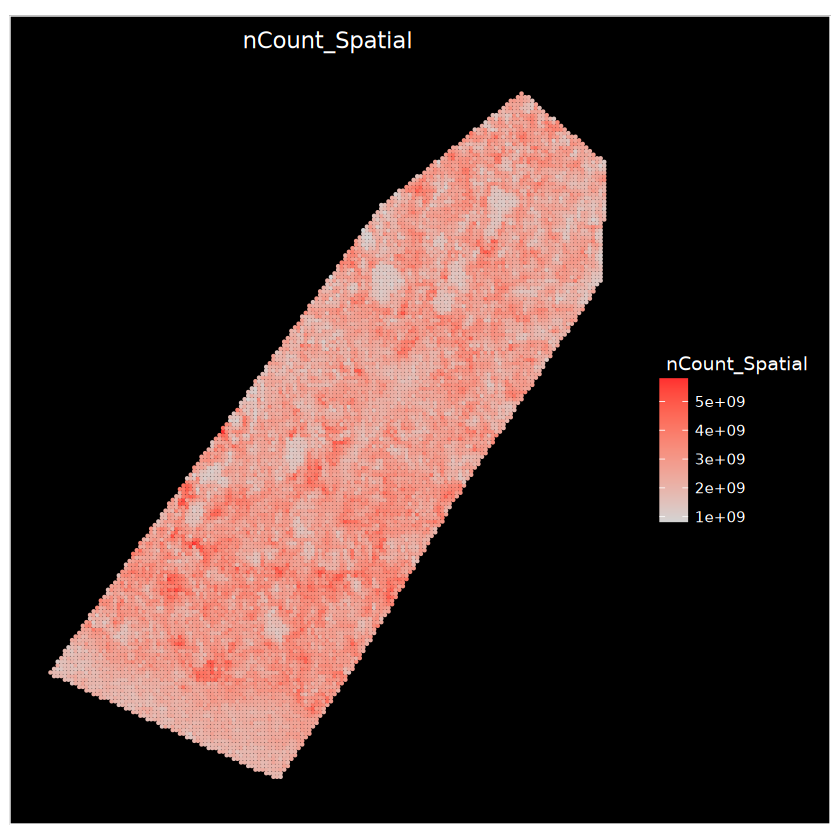

In [3]:
ImageFeaturePlot(data, features = "nCount_Spatial", size = 1)

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”


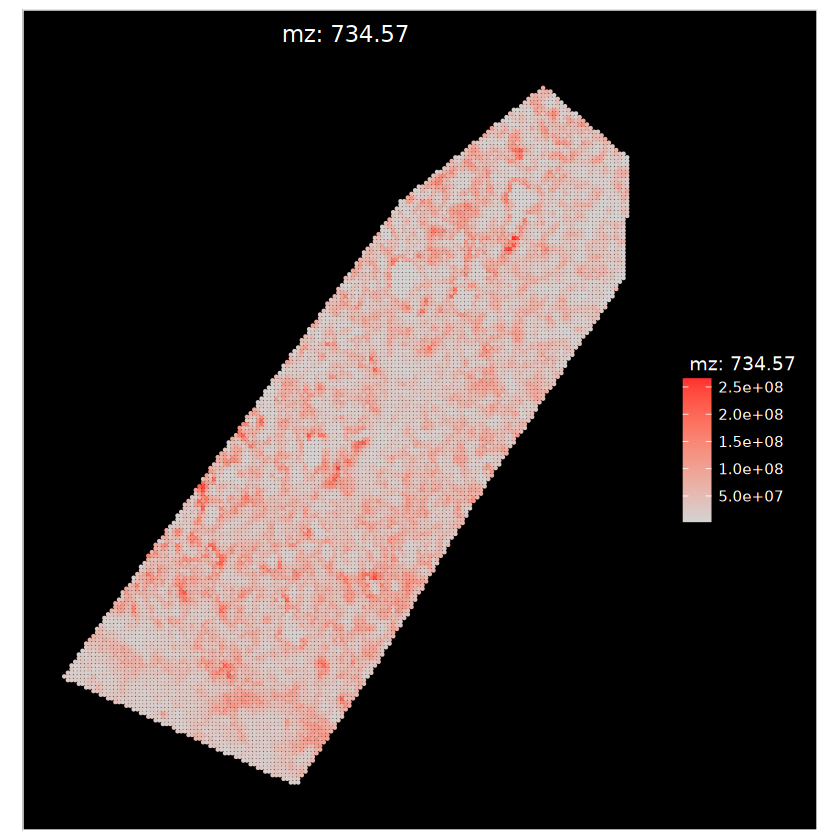

In [4]:
ImageMZPlot(data, mz = 734.5694, size = 1)

In [7]:
data

An object of class Seurat 
401325 features across 12513 samples within 1 assay 
Active assay: Spatial (401325 features, 0 variable features)
 1 layer present: counts
 1 spatial field of view present: fov

In [5]:
meta.data <- read.csv("/scratch/user/uqacause/files/project_data_objects/SpaMTP/Test_Data/metaspace_annotations_HMDB.csv", skip =2)

### HMDB_db results
HMDB_list <- list()
difference <- list()

suppressWarnings({
    for (adduct_n in unique(meta.data$adduct)){
    
        SpaMTP_Annoated <- AnnotateSM(data, db = HMDB_db, polarity = "pos", test_add_pos = c(adduct_n), ppm_error = 3)
        difference[[adduct_n]] <- dim(SpaMTP_Annoated)[1]
        meta.data.adduct <- meta.data[meta.data$adduct %in% adduct_n,]
        meta.data.adduct <- meta.data.adduct[meta.data.adduct$fdr != "0.5",]
    
        mzs <- c()
        for (i in meta.data.adduct$mz) {
            mz <- FindNearestMZ(SpaMTP_Annoated, i)
            mzs <- c(mzs, mz)
        }
        
        annotated_data <- SubsetMZFeatures(SpaMTP_Annoated, features = mzs)
        
        df <- data.frame(METASPACE_MZ = meta.data.adduct$mz, SpaMTP_MZ = mzs)
    
        lst <- lapply(df$SpaMTP_MZ, function(x){
            met <- annotated_data@assays$Spatial@meta.data[annotated_data@assays$Spatial@meta.data$mz_names == x,]
            list(SpaMTP_Annotation = met$all_IsomerNames,
                 SpaMTP_HMDB = met$all_Isomers,
                 SpaMTP_Adduct = met$all_Adducts)
        })
        
        annotations <- c()
        hmdb_ids <- c()
        adduct_ids <- c()
        
        # Iterate over each inner list
        for (entry in lst) {
          annotations <- c(annotations, entry$SpaMTP_Annotation)
          hmdb_ids <- c(hmdb_ids, entry$SpaMTP_HMDB)
          adduct_ids <- c(adduct_ids, entry$SpaMTP_Adduct)
        }
        
        lst <- lapply(df$METASPACE_MZ, function(x){
            met <- meta.data.adduct[meta.data.adduct$mz == x,]
            list(METASPACE_Annotation = met$moleculeNames,
                 METASPACE_HMDB = met$moleculeIds,
                METASPACE_Adduct = met$adduct)
        })
        
        annotations2 <- c()
        hmdb_ids2 <- c()
        adduct_ids2 <- c()
        
        # Iterate over each inner list
        for (entry in lst) {
          annotations2 <- c(annotations2, entry$METASPACE_Annotation)
          hmdb_ids2 <- c(hmdb_ids2, entry$METASPACE_HMDB)
          adduct_ids2 <- c(adduct_ids2, entry$METASPACE_Adduct)
        }
        
        
        
        df$SpaMTP_Annotation <- annotations
        df$METASPACE_Annotation <- annotations2
        df$SpaMTP_HMDB <- hmdb_ids
        df$METASPACE_HMDB <- hmdb_ids2
        df$SpaMTP_Adduct <- adduct_ids
        df$METASPACE_Adduct <- adduct_ids2  
    
    
        spamt_words <- strsplit(df$SpaMTP_Annotation, "; ")
        metaspace_words <- strsplit(df$METASPACE_Annotation, ", ")
        
        # Function to check if any word in metaspace_words exists in spamt_words
        check_overlap <- function(spamt_words, metaspace_words) {
          any(sapply(spamt_words, function(spamt_word) any(sapply(metaspace_words, function(metaspace_word) spamt_word %in% metaspace_word))))
        }
        
        # Apply the function row-wise
        df$Annotation_Overlap <- mapply(check_overlap, spamt_words, metaspace_words)
    
                                                                  
        HMDB_list[[adduct_n]] <- df                                
    }
})
    
matches <- lapply(names(HMDB_list), function(x){table(HMDB_list[[x]]$Annotation_Overlap)})
names(matches) <- names(HMDB_list)

HMDB_result <- do.call(rbind, lapply(names(matches), function(name) {
  tbl <- matches[[name]]
   df <- data.frame(adduct = name, Different = tbl["FALSE"], Match = tbl["TRUE"], SpaMTP_Identified = (difference[[name]] - sum(tbl)))
}))

rownames(HMDB_result) <- HMDB_result$adduct
HMDB_result$adduct <- NULL


Filtering 'HMDB_db' database by M+Na adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features

Filtering 'HMDB_db' database by M+H adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features

Filtering 'HMDB_db' database by M+K adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features



In [3]:
meta.data <- read.csv("/scratch/user/uqacause/files/project_data_objects/SpaMTP/Test_Data/metaspace_annotations_lipidmaps.csv", skip =2)

### LipidMaps Results
lipidmaps_list <- list()
difference <- list()
suppressWarnings({
    for (adduct_n in unique(meta.data$adduct)){
    
        SpaMTP_Annoated <- AnnotateSM(data, db = Lipidmaps_db, polarity = "pos", test_add_pos = c(adduct_n), ppm_error = 3)
        difference[[adduct_n]] <- dim(SpaMTP_Annoated)[1]
        meta.data.adduct <- meta.data[meta.data$adduct %in% adduct_n,]
        meta.data.adduct <- meta.data.adduct[meta.data.adduct$fdr != "0.5",]
    
        mzs <- c()
        for (i in meta.data.adduct$mz) {
            mz <- FindNearestMZ(SpaMTP_Annoated, i)
            mzs <- c(mzs, mz)
        }
        
        annotated_data <- SubsetMZFeatures(SpaMTP_Annoated, features = mzs)
        
        df <- data.frame(METASPACE_MZ = meta.data.adduct$mz, SpaMTP_MZ = mzs)
    
        lst <- lapply(df$SpaMTP_MZ, function(x){
            met <- annotated_data@assays$Spatial@meta.data[annotated_data@assays$Spatial@meta.data$mz_names == x,]
            list(SpaMTP_Annotation = met$all_IsomerNames,
                 SpaMTP_HMDB = met$all_Isomers,
                 SpaMTP_Adduct = met$all_Adducts)
        })
        
        annotations <- c()
        hmdb_ids <- c()
        adduct_ids <- c()
        
        # Iterate over each inner list
        for (entry in lst) {
          annotations <- c(annotations, entry$SpaMTP_Annotation)
          hmdb_ids <- c(hmdb_ids, entry$SpaMTP_HMDB)
          adduct_ids <- c(adduct_ids, entry$SpaMTP_Adduct)
        }
        
        lst <- lapply(df$METASPACE_MZ, function(x){
            met <- meta.data.adduct[meta.data.adduct$mz == x,]
            list(METASPACE_Annotation = met$moleculeNames,
                 METASPACE_HMDB = met$moleculeIds,
                METASPACE_Adduct = met$adduct)
        })
        
        annotations2 <- c()
        hmdb_ids2 <- c()
        adduct_ids2 <- c()
        
        # Iterate over each inner list
        for (entry in lst) {
          annotations2 <- c(annotations2, entry$METASPACE_Annotation)
          hmdb_ids2 <- c(hmdb_ids2, entry$METASPACE_HMDB)
          adduct_ids2 <- c(adduct_ids2, entry$METASPACE_Adduct)
        }
        
        
        
        df$SpaMTP_Annotation <- annotations
        df$METASPACE_Annotation <- annotations2
        df$SpaMTP_HMDB <- hmdb_ids
        df$METASPACE_HMDB <- hmdb_ids2
        df$SpaMTP_Adduct <- adduct_ids
        df$METASPACE_Adduct <- adduct_ids2  
    
    
        spamt_words <- strsplit(df$SpaMTP_Annotation, "; ")
        metaspace_words <- strsplit(df$METASPACE_Annotation, ", ")
        
        # Function to check if any word in metaspace_words exists in spamt_words
        check_overlap <- function(spamt_words, metaspace_words) {
          any(sapply(spamt_words, function(spamt_word) any(sapply(metaspace_words, function(metaspace_word) spamt_word %in% metaspace_word))))
        }
        
        # Apply the function row-wise
        df$Annotation_Overlap <- mapply(check_overlap, spamt_words, metaspace_words)
    
                                                                  
        lipidmaps_list[[adduct_n]] <- df                                
    }
})
    
matches <- lapply(names(lipidmaps_list), function(x){table(lipidmaps_list[[x]]$Annotation_Overlap)})
names(matches) <- names(lipidmaps_list)

lipidmaps_result <- do.call(rbind, lapply(names(matches), function(name) {
  tbl <- matches[[name]]
  df <- data.frame(adduct = name, Different = tbl["FALSE"], Match = tbl["TRUE"], SpaMTP_Identified = (difference[[name]] - sum(tbl)))
}))

rownames(lipidmaps_result) <- lipidmaps_result$adduct
lipidmaps_result$adduct <- NULL

Filtering 'Lipidmaps_db' database by M+H adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features

Filtering 'Lipidmaps_db' database by M+Na adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features

Filtering 'Lipidmaps_db' database by M+K adduct/s

Searching database against input m/z's to return annotaiton results

Adding annotations to Seurat Object .... 

Returning Seurat object that include ONLY SUCCESSFULLY ANNOTATED m/z features



In [8]:
rbind("HMDB" = colSums(HMDB_result),"LipidMaps" = colSums(lipidmaps_result))

,Different,Match,SpaMTP_Identified
HMDB,32,215,81235
LipidMaps,22,300,39215


In [4]:
merged_df <- bind_rows(lipidmaps_list)

In [11]:
merged_df <- bind_rows(HMDB_list)

In [5]:
write.csv(merged_df, "/scratch/user/uqacause/files/project_data_objects/SpaMTP/lipidmap_metaspace_comp.csv")

In [13]:
merged_df[merged_df$Annotation_Overlap == "FALSE",]

,METASPACE_MZ,SpaMTP_MZ,SpaMTP_Annotation,METASPACE_Annotation,SpaMTP_HMDB,METASPACE_HMDB,SpaMTP_Adduct,METASPACE_Adduct,Annotation_Overlap
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
9,527.1346,mz-527.134363180876,Clindamycin phosphate,"{4-[5,7-dihydroxy-8-(3-methylbut-2-en-1-yl)-4-oxo-3,4-dihydro-2H-1-benzopyran-3-yl]-2-hydroxy-6-(3-methylbut-2-en-1-yl)phenyl}oxidanesulfonic acid",HMDB0250324,HMDB0134748,M+Na,M+Na,FALSE
13,273.0417,mz-300.00630006615,Fenitrothion,Sulfadiazine,HMDB0041893,HMDB0014503,M+Na,M+Na,FALSE
14,339.0687,mz-339.068948516164,Ginnalin B; Protocatechuic acid 4-glucoside,"3,4,5-trihydroxy-6-(2-hydroxy-3-methoxyphenoxy)oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-(2-hydroxy-6-methoxyphenoxy)oxane-2-carboxylic acid",HMDB0252723; HMDB0303826,"HMDB0128036, HMDB0128037",M+Na,M+Na,FALSE
15,533.0902,mz-533.093310070622,cefuroxime axetil,"3,4,5-trihydroxy-6-{[3,6,7-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-4-oxo-3,4-dihydro-2H-1-benzopyran-5-yl]oxy}oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-{[3,5,7-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-4-oxo-3,4-dihydro-2H-1-benzopyran-6-yl]oxy}oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-{[3,5,6-trihydroxy-2-(4-hydroxy-3-methoxyphenyl)-4-oxo-3,4-dihydro-2H-1-benzopyran-7-yl]oxy}oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-[2-methoxy-4-(3,5,6,7-tetrahydroxy-4-oxo-3,4-dihydro-2H-1-benzopyran-2-yl)phenoxy]oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-{2,3,5-trihydroxy-6-[3-(4-hydroxy-3-methoxyphenyl)-2-oxopropanoyl]phenoxy}oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-{2,4,6-trihydroxy-3-[3-(4-hydroxy-3-methoxyphenyl)-2-oxopropanoyl]phenoxy}oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-{2,3,5-trihydroxy-4-[3-(4-hydroxy-3-methoxyphenyl)-2-oxopropanoyl]phenoxy}oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-{3,4,5-trihydroxy-2-[3-(4-hydroxy-3-methoxyphenyl)-2-oxopropanoyl]phenoxy}oxane-2-carboxylic acid, 6-{4-[2,3-dioxo-3-(2,3,4,6-tetrahydroxyphenyl)propyl]-2-methoxyphenoxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{[2-(3,4-dihydroxyphenyl)-3,7-dihydroxy-6-methoxy-4-oxo-3,4-dihydro-2H-1-benzopyran-5-yl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{[2-(3,4-dihydroxyphenyl)-3,5-dihydroxy-6-methoxy-4-oxo-3,4-dihydro-2H-1-benzopyran-7-yl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 3,4,5-trihydroxy-6-[2-hydroxy-4-(3,5,7-trihydroxy-6-methoxy-4-oxo-3,4-dihydro-2H-1-benzopyran-2-yl)phenoxy]oxane-2-carboxylic acid, 3,4,5-trihydroxy-6-[2-hydroxy-5-(3,5,7-trihydroxy-6-methoxy-4-oxo-3,4-dihydro-2H-1-benzopyran-2-yl)phenoxy]oxane-2-carboxylic acid, 6-{2-[3-(3,4-dihydroxyphenyl)-2-oxopropanoyl]-3,5-dihydroxy-6-methoxyphenoxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{4-[3-(3,4-dihydroxyphenyl)-2-oxopropanoyl]-3,5-dihydroxy-2-methoxyphenoxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{2-[3-(3,4-dihydroxyphenyl)-2-oxopropanoyl]-3,5-dihydroxy-4-methoxyphenoxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{4-[2,3-dioxo-3-(2,4,6-trihydroxy-3-methoxyphenyl)propyl]-2-hydroxyphenoxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{5-[2,3-dioxo-3-(2,4,6-trihydroxy-3-methoxyphenyl)propyl]-2-hydroxyphenoxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{[4,5-dihydroxy-6-({7-oxo-7H-furo[3,2-g]chromen-9-yl}oxy)oxan-3-yl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{[3,5-dihydroxy-2-({7-oxo-7H-furo[3,2-g]chromen-9-yl}oxy)oxan-4-yl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid, 6-{[4,5-dihydroxy-2-({7-oxo-7H-furo[3,2-g]chromen-9-yl}oxy)oxan-3-yl]oxy}-3,4,5-trihydroxyoxane-2-carboxylic acid",HMDB0249787,"HMDB0128791, HMDB0128792, HMDB0128793, HMDB0128794, HMDB0128801, HMDB0128802, HMDB0128803, HMDB0128804, HMDB0128805, HMDB0128815, HMDB0128816, HMDB0128817, HMDB0128818, HMDB0128826, HMDB0128827, HMDB0128828, HMDB0128829, HMDB0128830, HMDB0134871, HMDB0134869, HMDB0134870",M+Na,M+Na,FALSE
23,544.3374,mz-544.33805290848,LysoPC(18:1(9Z)/0:0); LysoPC(18:1(11Z)/0:0); LysoPC(0:0/18:1(9Z)); PC(18:1(6Z)/0:0),"LysoPC(18:1(9Z)), LysoPC(18:1(11Z)), 2-oleoyl-sn-glycero-3-phosphocholine",HMDB0002815; HMDB0010385; HMDB006170